In [1]:
%load_ext autoreload
%autoreload 2

## Liège city dataset

In [2]:
import json
import random
import via as VIA

from dataset import VIADataset, RandomTranspose, ToTensor

via = VIA.load('../resources/walonmap/via_liege_city.json')

keys = sorted(list(via.keys()))

random.seed(0)
random.shuffle(keys)

train_via = {key: via[key] for key in keys[:550]}
valid_via = {key: via[key] for key in keys[550:]}

trainset = ToTensor(RandomTranspose(VIADataset(train_via, '../products/liege/', size=None, shuffle=True)))
validset = ToTensor(VIADataset(valid_via, '../products/liege/', size=None, shuffle=True))

print('Training size = {}'.format(len(trainset)))
print('Validation size = {}'.format(len(validset)))

Training size = 550
Validation size = 111


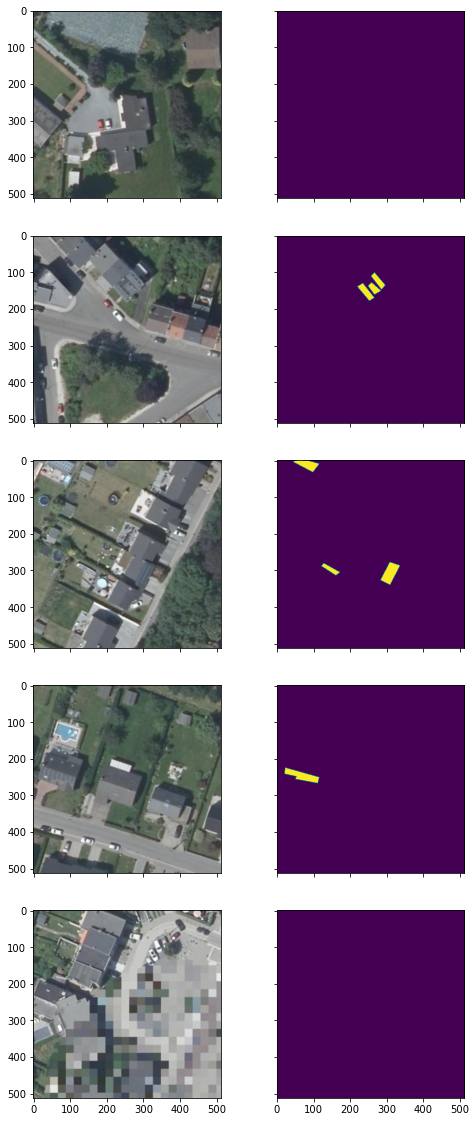

In [3]:
from torch.utils.data import DataLoader
from dataset import to_pil
from plots import plot_alongside

trainloader = DataLoader(trainset, batch_size=2)
validloader = DataLoader(validset, batch_size=5)

for inputs, targets in validloader:
    break

plot_alongside(
    map(to_pil, inputs),
    map(to_pil, targets)
)

## Model

The model used is **U-Net**, trained for `36` epochs on the california dataset with the `DiceLoss` loss function.

In [4]:
import torch
from torchsummary import summary
from models import UNet

model = UNet(3, 1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

model.load_state_dict(torch.load('../products/models/unet_x2_036.pth', map_location=device))

<All keys matched successfully>

## Average Precision

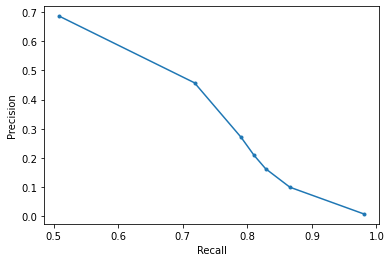

In [5]:
import numpy as np
import train
import matplotlib.pyplot as plt

from criterions import TP, TN, FP, FN

metrics = train.eval(
    model,
    validloader,
    [m(x) for m in [TP, TN, FP, FN] for x in [1e-6, 1e-3, 0.1, 0.5, 0.9, 1 - 1e-3, 1 - 1e-6]]
)

metrics = np.array(metrics).sum(axis=0).reshape((4, -1))

precision = metrics[0] / (metrics[0] + metrics[2])
recall = metrics[0] / (metrics[0] + metrics[3])

plt.plot(recall, precision, '.-')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.tight_layout()
plt.savefig('../products/precision_recall_before.pdf', transparent=True)
plt.show()

In [6]:
from criterions import DiceLoss
from torch.optim import Adam

criterion = DiceLoss(smooth=1.)
optimizer = Adam(model.parameters(), lr=1e-4)

for epoch in range(20):
    losses = train.train_epoch(model, trainloader, criterion, optimizer)
    print('Epoch {} : loss = {}'.format(epoch, np.mean(losses)))

Epoch 0 : loss = 0.63324500430714
Epoch 1 : loss = 0.5396127707307989
Epoch 2 : loss = 0.5328598642349243
Epoch 3 : loss = 0.5278848856145686
Epoch 4 : loss = 0.5150864336707375
Epoch 5 : loss = 0.5003989011591131
Epoch 6 : loss = 0.49740349986336446
Epoch 7 : loss = 0.4962802960655906
Epoch 8 : loss = 0.5117763064124368
Epoch 9 : loss = 0.5022707752747969
Epoch 10 : loss = 0.4961747704852711
Epoch 11 : loss = 0.4995724320411682
Epoch 12 : loss = 0.4922575458613309
Epoch 13 : loss = 0.5017707816037265
Epoch 14 : loss = 0.4941709110953591
Epoch 15 : loss = 0.47016511483625933
Epoch 16 : loss = 0.4868912809545344
Epoch 17 : loss = 0.4762561386281794
Epoch 18 : loss = 0.48131408604708587
Epoch 19 : loss = 0.4796156677332791


In [7]:
torch.save(model.state_dict(), '../products/models/unet_x2_036_20.pth')

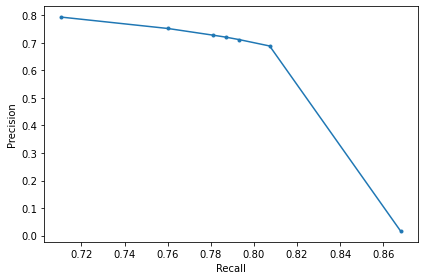

In [8]:
metrics = train.eval(
    model,
    validloader,
    [m(x) for m in [TP, TN, FP, FN] for x in [1e-6, 1e-3, 0.1, 0.5, 0.9, 1 - 1e-3, 1 - 1e-6]]
)

metrics = np.array(metrics).sum(axis=0).reshape((4, -1))

precision = metrics[0] / (metrics[0] + metrics[2])
recall = metrics[0] / (metrics[0] + metrics[3])

plt.plot(recall, precision, '.-')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.tight_layout()
plt.savefig('../products/precision_recall_after.pdf', transparent=True)
plt.show()

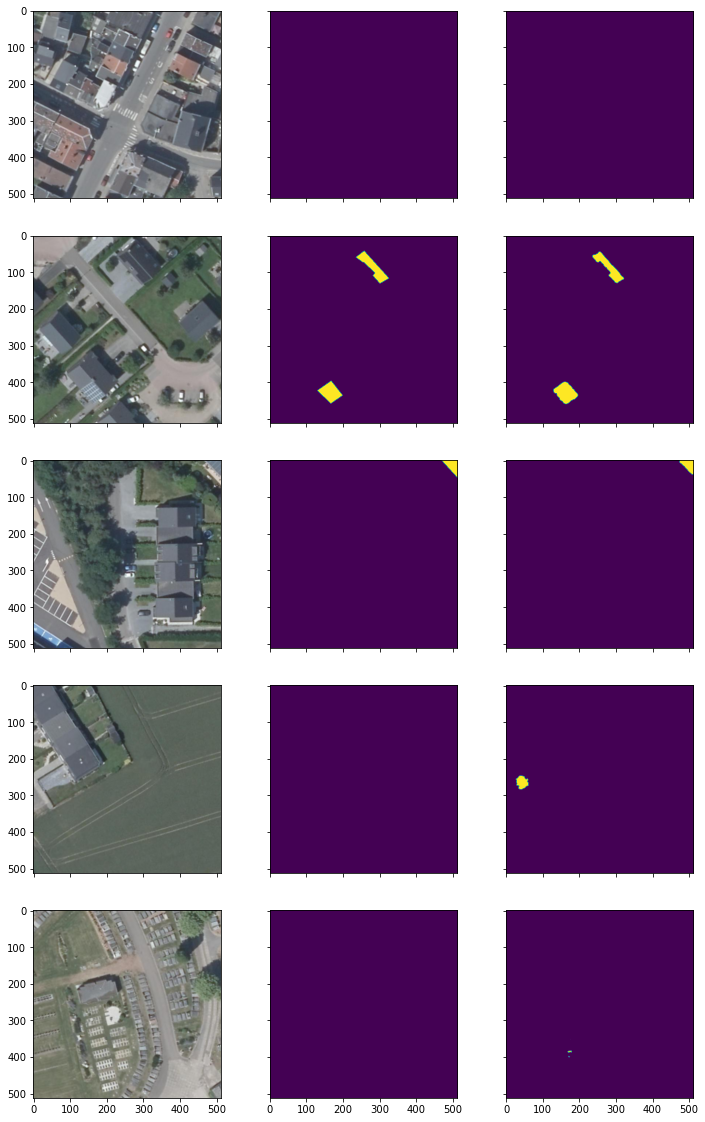

In [9]:
model.eval()

with torch.no_grad():
    for inputs, targets in validloader:
        break

    inputs = inputs.to(device)
    outputs = model(inputs)

plot_alongside(
    map(to_pil, inputs.cpu()),
    map(to_pil, targets),
    map(to_pil, outputs.cpu())
)